# Analyse Notebook

## 1. Introductie

In dit hoofdstuk worden de resultaten van het onderzoek gepresenteerd. 
Eerst wordt een overzicht gegeven van de deelnemers en hun waarderingen, 
vervolgens de kenmerken van de geselecteerde jaren-80 nummers, 
en daarna de samenhang tussen audiofeatures en waardering. 
Tot slot wordt onderzocht hoe goed eenvoudige lineaire modellen de waardering kunnen voorspellen.

In [55]:
# Importeren van de relevante Python-bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

## 2. Selectie van muziekfragmenten

De analyse is uitgevoerd op 20 geselecteerde jaren-80 nummers met beschikbare Spotify-audiofeatures. De selectie bevat voldoende variatie in valence, energy en tempo.


In [115]:
# Selectie van 20 willekeurige jaren-80 nummers uit de volledige dataset (n = 998)
df = pd.read_csv('1980sClassics.csv')
sample = df.sample(n=20, random_state=3)
sample.to_csv("random_20.csv", index=False)

# Controle op voldoende diversiteit binnen de geselecteerde nummers
for col in ['Valence', 'Energy', 'Tempo']:
    val_range = sample[col].max() - sample[col].min()
    print(col, 'range =', round(val_range, 3))

sample.index = range(1, len(sample) + 1)

# Formatteren van de labels naar een tweecijferige notatie (01–20)
sample.index = sample.index.map(lambda x: f"{x:02d}")

Valence range = 0.894
Energy range = 0.911
Tempo range = 113.953


## 3. Resultaten deelnemers

### 3.1 Opschonen resultaten
Eerst wordt de dataset met resultaten opgeschoond. Niet-relevante kolommen worden verwijderd en de waarderingen van de nummers worden omgezet naar een numerieke schaal. Daarnaast worden deelnemers zonder volledige antwoorden uitgesloten van de analyse.

In [130]:
# Resultaten deelnemers
results = pd.read_csv('Scriptie Froukje_January 2, 2026_04.07.csv')

# Opschonen van niet-relevante kolommen
results = results.drop(columns=[
    "StartDate","EndDate","Status","IPAddress","Progress","Duration (in seconds)",
    "Finished","RecordedDate","ResponseId","RecipientLastName","RecipientFirstName",
    "RecipientEmail","ExternalReference","LocationLatitude","LocationLongitude",
    "DistributionChannel","UserLanguage","QID4"
])

# De eerste twee rijen verwijderen (metadata/header)
results = results.iloc[2:].reset_index(drop=True)

# Omzetten van waarderingen naar numerieke schaal
results = results.replace({
    "1: Ik vind het niet mooi": 1,
    "2: Ik vind het redelijk": 2,
    "3: Ik vind het mooi": 3,
    "4: Ik vind het heel mooi": 4
})

# Laatste 20 kolommen zijn de ratings van de 20 nummers
results_ratings = results.iloc[:, -20:]

# Verwijder onvolledige antwoorden
results_ratings_clean = results_ratings.dropna(how="all")


/var/folders/c7/tdk__2qd1qxdg3djh5cc8d500000gn/T/ipykernel_26479/481734113.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results = results.replace({


### 3.2 Beschrijvende statistieken
De analyses zijn gebaseerd op de deelnemers die alle relevante vragen hebben beantwoord. 
Hieronder wordt een overzicht gegeven van het aantal deelnemers en relevante demografische kenmerken leeftijd, geslacht en muzikale achtergrond.


In [135]:
# Aantal deelnemers
n_participants = results_ratings_clean.shape[0]
print(f"Aantal deelnemers: {n_participants}")

# Selecteer de rijen van de deelnemers die ratings hebben ingevuld
participants_clean = results.loc[results_ratings_clean.index, ['Q7','Q6','Q9']].copy()
participants_clean.columns = ['Leeftijd', 'Geslacht', 'Muzikale_achtergrond']

# Geslacht
gender_counts = participants_clean['Geslacht'].value_counts()
gender_percent = participants_clean['Geslacht'].value_counts(normalize=True)*100

# Leeftijd (categorisch)
age_counts = participants_clean['Leeftijd'].value_counts()
age_percent = participants_clean['Leeftijd'].value_counts(normalize=True)*100

# Muzikale achtergrond (categorisch)
music_counts = participants_clean['Muzikale_achtergrond'].value_counts()
music_percent = participants_clean['Muzikale_achtergrond'].value_counts(normalize=True)*100

# Maak overzichtelijke tabellen
age_table = pd.DataFrame({
    'Aantal': age_counts,
    'Percentage': age_percent.round(1)
}).sort_index()

gender_table = pd.DataFrame({
    'Aantal': gender_counts,
    'Percentage': gender_percent.round(1)
})

music_table = pd.DataFrame({
    'Aantal': music_counts,
    'Percentage': music_percent.round(1)
})

# Toon tabellen
display(age_table)
display(gender_table)
display(music_table)


Aantal deelnemers: 31


,Aantal,Percentage
Leeftijd,,
65-69 jaar,8,25.8
70-74 jaar,7,22.6
75-79 jaar,7,22.6
80-85 jaar,6,19.4
Zeg ik liever niet,3,9.7


,Aantal,Percentage
Geslacht,,
Man,21,67.7
Vrouw,10,32.3


,Aantal,Percentage
Muzikale_achtergrond,,
"Ik speelde vroeger een (of meerdere) instrument(en) of ik zong, maar nu niet meer",12,40.0
Ik heb geen muzikale achtergrond,10,33.3
"Ik speelde vroeger een (of meerdere) instrument(en) of ik zong, en nu nog steeds",7,23.3
Ik heb een professionele muzikale achtergrond,1,3.3


### 3.3 Gemiddelde rating per nummer
De gemiddelde waardering laat zien welke nummers door de deelnemers als het mooist werden ervaren.

In [136]:
# Gemiddelde, standaarddeviatie, min en max van de waardering per nummer
mean_ratings = results_ratings_clean.mean()
std_ratings = results_ratings_clean.std()
min_ratings = results_ratings_clean.min()
max_ratings = results_ratings_clean.max()

ratings_summary = pd.DataFrame({
    'Gemiddelde': mean_ratings,
    'StdDev': std_ratings,
    'Min': min_ratings,
    'Max': max_ratings
})

print("Overzicht ratings per nummer:")
print(ratings_summary)

# Algemene gemiddelde rating over alle nummers
overall_mean = results_ratings_clean.values.flatten().mean()

print(f"Algemene gemiddelde rating over alle nummers: {overall_mean:.2f}")


Overzicht ratings per nummer:
    Gemiddelde    StdDev  Min  Max
01    1.903226  0.830857  1.0  4.0
02    2.451613  0.850047  1.0  4.0
03    2.161290  0.934408  1.0  4.0
04    2.806452  0.980454  1.0  4.0
05    1.741935  0.773207  1.0  3.0
06    2.225806  0.844972  1.0  4.0
07    1.677419  0.791079  1.0  3.0
08    1.322581  0.540808  1.0  3.0
09    1.806452  0.833441  1.0  4.0
10    2.161290  0.934408  1.0  4.0
11    1.935484  0.813858  1.0  3.0
12    2.709677  1.070624  1.0  4.0
13    1.483871  0.625618  1.0  3.0
14    1.709677  0.739078  1.0  3.0
15    1.612903  0.667204  1.0  3.0
16    1.838710  0.687836  1.0  4.0
17    2.129032  0.921663  1.0  4.0
18    2.225806  0.762001  1.0  4.0
19    2.064516  0.963863  1.0  4.0
20    2.838710  1.003221  1.0  4.0
Algemene gemiddelde rating over alle nummers: 2.04


## 4. Analyse

### 4.1 Correlatie audiofeatures met gemiddelde rating
De correlaties geven inzicht in welke audiofeatures mogelijk invloed hebben op de waardering van de nummers.

In [137]:
# Alleen numerieke kolommen selecteren
numeric_df = sample.select_dtypes(include='number')
numeric_df['mean_rating'] = mean_ratings

# Correlaties berekenen tussen audiofeatures en gemiddelde rating
correlations = numeric_df.corr()['mean_rating'].sort_values(ascending=False)
print("Correlatie per audiofeature met gemiddelde rating:")
print(correlations)

Correlatie per audiofeature met gemiddelde rating:
mean_rating         1.000000
Acousticness        0.590139
Tempo               0.271785
Mode                0.165992
Time_Signature      0.129924
Key                 0.048898
Speechiness         0.047726
Instrumentalness   -0.108040
Popularity         -0.130621
Year               -0.152805
Loudness           -0.174239
Liveness           -0.230975
Danceability       -0.490978
Energy             -0.580512
Valence            -0.615301
Name: mean_rating, dtype: float64


### 4.2 Visualisatie van correlaties
Onderstaande heatmap geeft een visueel overzicht van de samenhang tussen alle audiofeatures en de gemiddelde waardering van de nummers.

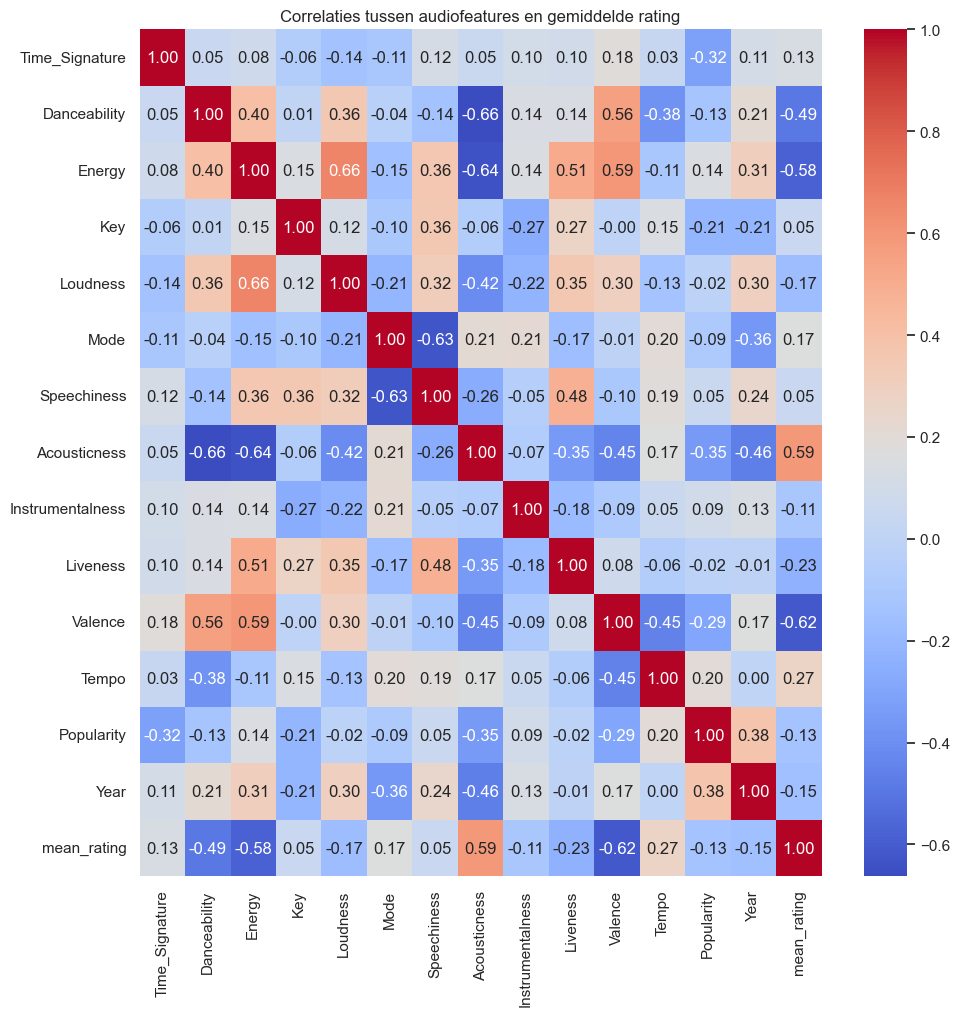

In [138]:
plt.figure(figsize=(11,11))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlaties tussen audiofeatures en gemiddelde rating")
plt.show()

### 4.3 Heatmap met relevante audiofeatures
Onderstaande heatmap geeft een visueel overzicht van de samenhang tussen Valence, Energy, Danceability en Acousticness met de gemiddelde rating. 


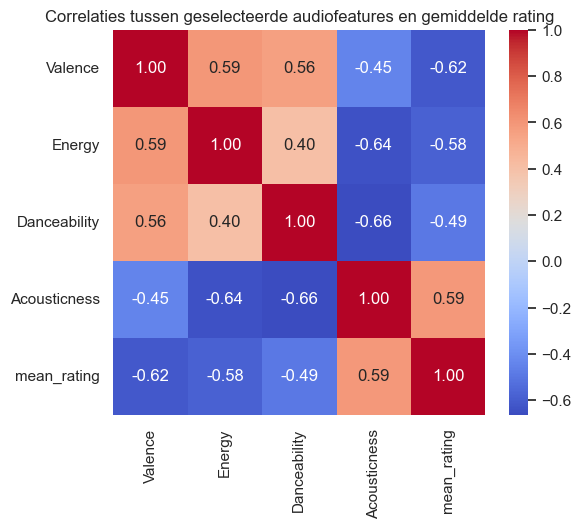

In [139]:
relevant_features = ['Valence', 'Energy', 'Danceability', 'Acousticness']
numeric_df_subset = numeric_df[relevant_features + ['mean_rating']]

plt.figure(figsize=(6,5))
sns.heatmap(numeric_df_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlaties tussen geselecteerde audiofeatures en gemiddelde rating")
plt.show()

### 4.4 Scatterplots van relevante audiofeatures versus gemiddelde waardering
Om de richting en sterkte van de relaties tussen de belangrijkste audiofeatures en de waardering van de nummers visueel te maken, zijn scatterplots gemaakt. Dit laat zien welke eigenschappen bijdragen aan een hogere of lagere waardering door de deelnemers.

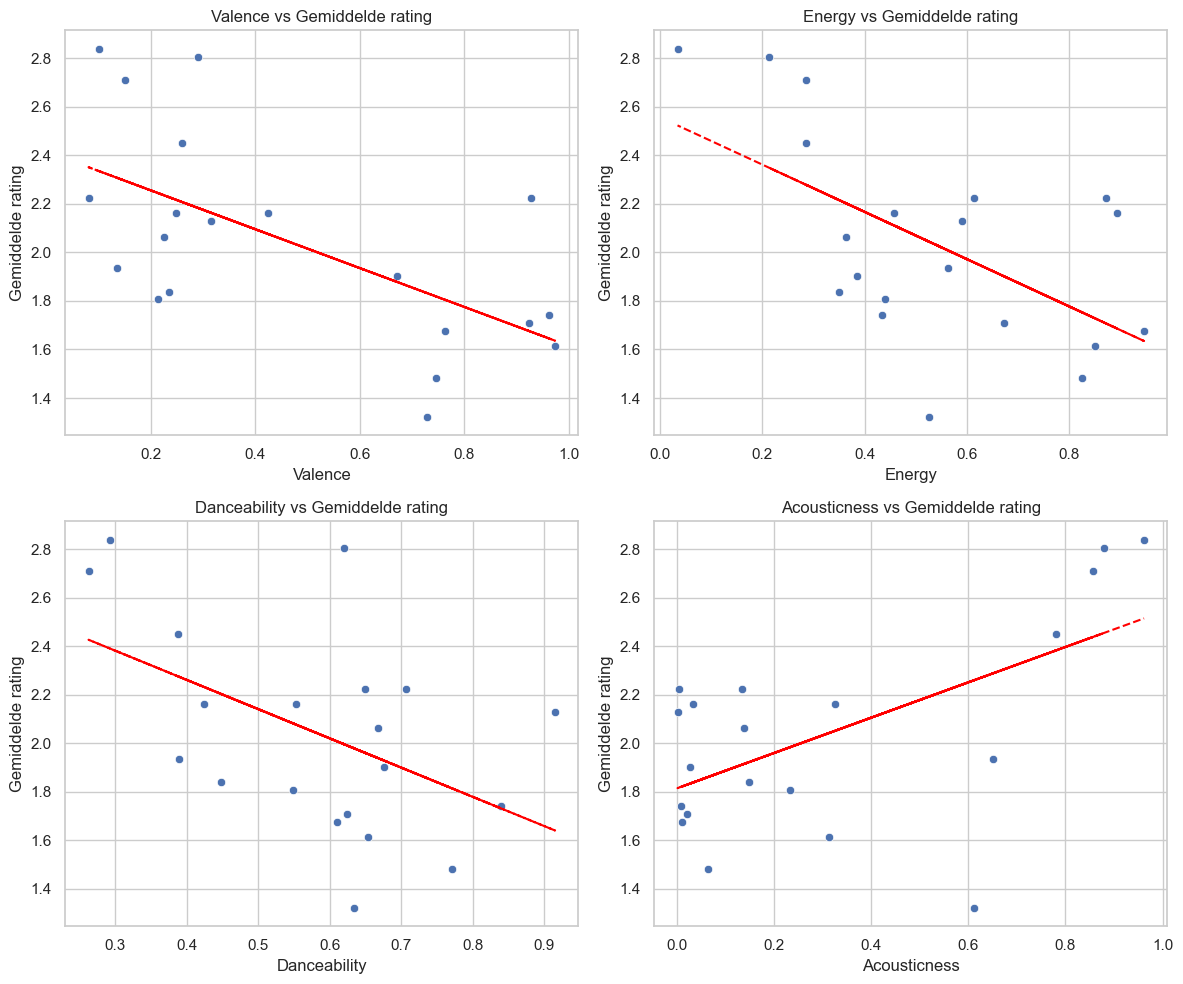

In [140]:
plt.figure(figsize=(12,10))
for i, feat in enumerate(relevant_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=numeric_df[feat], y=numeric_df['mean_rating'])
    plt.xlabel(feat)
    plt.ylabel("Gemiddelde rating")
    plt.title(f"{feat} vs Gemiddelde rating")
    
    m, b = np.polyfit(numeric_df[feat], numeric_df['mean_rating'], 1)
    plt.plot(numeric_df[feat], m*numeric_df[feat] + b, color='red', linestyle='--')
    
plt.tight_layout()
plt.show()

## 5. Voorspelling van waardering met lineaire modellen

Om te onderzoeken of de waardering van ouderen kan worden voorspeld op basis van de audiofeatures, is een eenvoudig lineair regressiemodel gebruikt.  
De vier belangrijkste audiofeatures (Valence, Energy, Danceability, Acousticness) dienen als voorspellende variabelen, en de gemiddelde rating als responsvariabele.

Er is zowel een train/test split gebruikt als cross-validation, zodat de prestaties van het model beter ingeschat kunnen worden ondanks de kleine steekproef.


In [141]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# X = de features, y = de gemiddelde rating
X = numeric_df[relevant_features]
y = numeric_df['mean_rating']

# Splitten in train en test set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model trainen
model = LinearRegression()
model.fit(X_train, y_train)

# Voorspellingen maken
y_pred = model.predict(X_test)

# Evaluatie
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R-squared: {r2:.3f}")


Mean Squared Error (MSE): 0.046
R-squared: 0.247


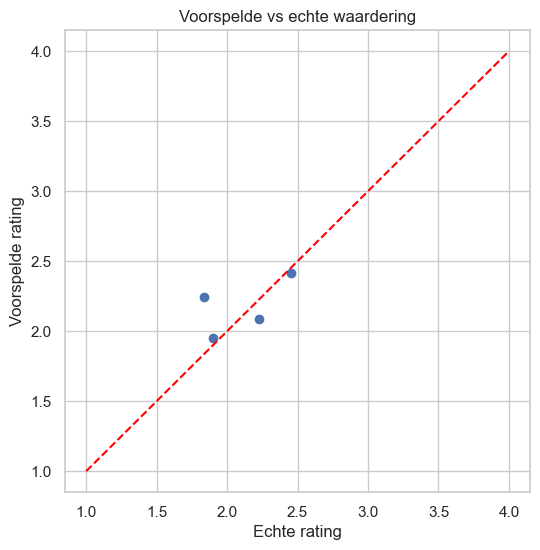

In [102]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred)
plt.plot([1,4],[1,4], color='red', linestyle='--')
plt.xlabel("Echte rating")
plt.ylabel("Voorspelde rating")
plt.title("Voorspelde vs echte waardering")
plt.show()


De cross-validation analyse laat zien hoe goed het model elk nummer kan voorspellen, waarbij alle 20 nummers in de evaluatie worden meegenomen.  

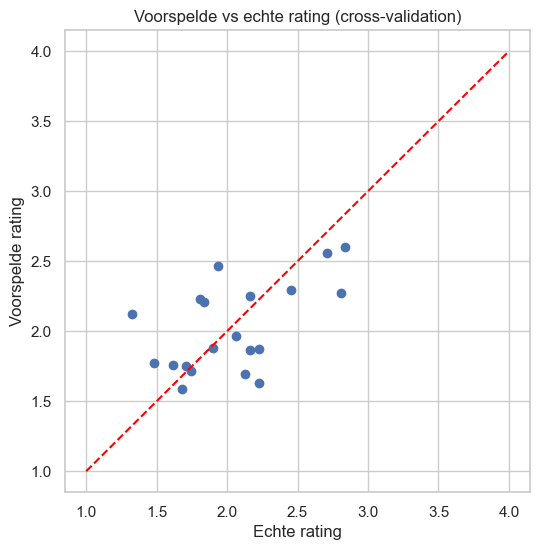

In [105]:
from sklearn.model_selection import cross_val_predict

y_pred_all = cross_val_predict(model, X, y, cv=5)

plt.figure(figsize=(6,6))
plt.scatter(y, y_pred_all)
plt.plot([1,4],[1,4], color='red', linestyle='--')
plt.xlabel("Echte rating")
plt.ylabel("Voorspelde rating")
plt.title("Voorspelde vs echte rating (cross-validation)")
plt.show()

### 5.1 Belang van de individuele audiofeatures

Naast de voorspellingen van het model, is het interessant om te bekijken welke features het meest bijdragen aan de voorspelling.  
Dit kan eenvoudig worden gedaan door de regressiecoëfficiënten van het lineaire model te bekijken.


In [110]:
# Coefficients van het lineaire model
feature_importance = pd.DataFrame({
    'Feature': relevant_features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

feature_importance

,Feature,Coefficient
1,Energy,-0.458800
0,Valence,-0.407116
2,Danceability,-0.325695
3,Acousticness,0.208027
